In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [54]:
# Load cell lines used in your study
bulk_all = pd.read_csv("../../data/processed/processed_bulk.csv")
bulk_all["SANGER_MODEL_ID"] = bulk_all["SANGER_MODEL_ID"].str.strip().str.upper()
used_models = bulk_all["SANGER_MODEL_ID"].unique()
print(f"✅ Loaded {len(used_models)} unique cell lines from processed_bulk.csv")


✅ Loaded 1431 unique cell lines from processed_bulk.csv


In [55]:
# Load tissue metadata
passport_df = pd.read_csv("../../data/original/model_tissue_list.csv")
passport_df["model_id"] = passport_df["model_id"].str.strip().str.upper()
passport_df["tissue"] = passport_df["tissue"].str.strip().str.title()

# Filter to only models used in the study
filtered_tissue_df = passport_df[passport_df["model_id"].isin(used_models)][["model_id", "tissue"]].dropna()
filtered_tissue_df = filtered_tissue_df.rename(columns={"model_id": "SANGER_MODEL_ID", "tissue": "Tissue"})


In [56]:
# Check for duplicate model IDs
duplicates = filtered_tissue_df["SANGER_MODEL_ID"].duplicated(keep=False)
if duplicates.any():
    print("⚠️ Warning: Found duplicated model IDs with different tissues.")
    print(filtered_tissue_df[duplicates].sort_values("SANGER_MODEL_ID"))

# Resolve duplicates by taking the most common tissue (mode)
filtered_tissue_df = (
    filtered_tissue_df.groupby("SANGER_MODEL_ID")["Tissue"]
    .agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])
    .reset_index()
)

print(f"✅ Final tissue mapping for {len(filtered_tissue_df)} model IDs")


✅ Final tissue mapping for 1431 model IDs


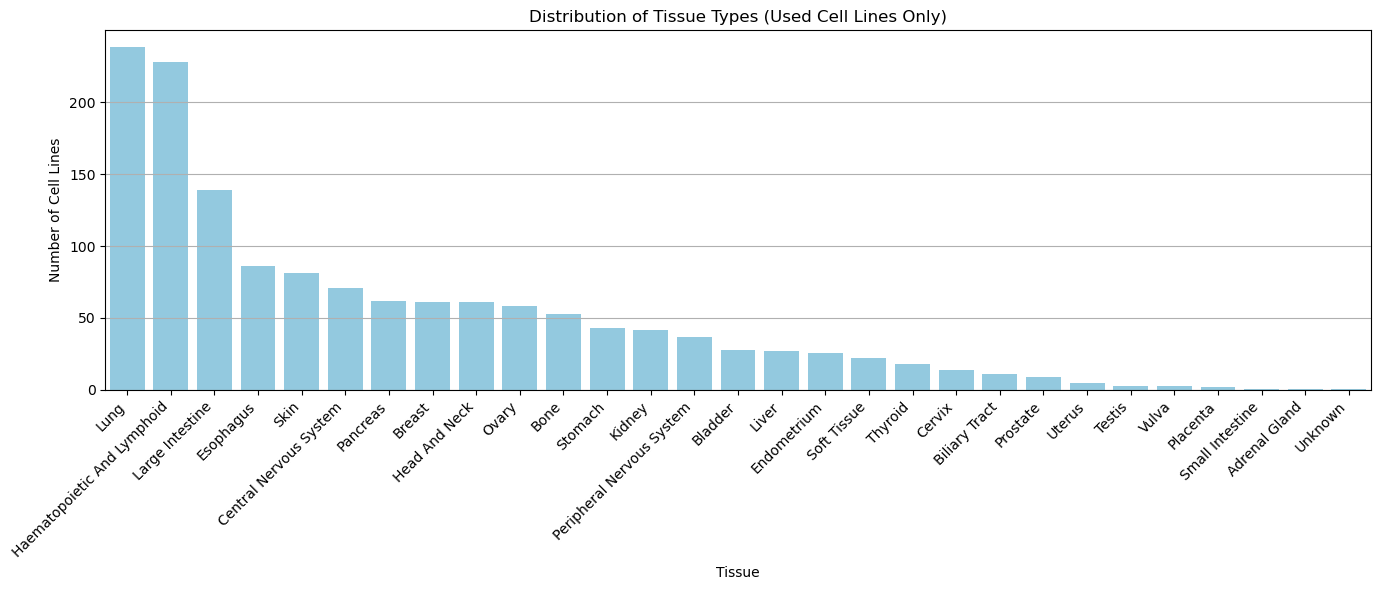

In [57]:
# Count tissue occurrences
tissue_counts = filtered_tissue_df["Tissue"].value_counts()

# Plot tissue distribution
plt.figure(figsize=(14, 6))
sns.barplot(x=tissue_counts.index, y=tissue_counts.values, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Tissue Types (Used Cell Lines Only)")
plt.xlabel("Tissue")
plt.ylabel("Number of Cell Lines")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [58]:
# Minimum count threshold
MIN_TISSUE_COUNT = 30
top_tissues = tissue_counts[tissue_counts >= MIN_TISSUE_COUNT].index.tolist()

# Assign "Other" to less common tissues
filtered_tissue_df["Tissue_Clean"] = filtered_tissue_df["Tissue"].apply(
    lambda x: x if x in top_tissues else "Other"
)


In [59]:
# One-hot encode the cleaned tissue column
tissue_dummies = pd.get_dummies(filtered_tissue_df["Tissue_Clean"], prefix="Tissue").astype(int)

# Combine with model ID
tissue_encoded_df = pd.concat([
    filtered_tissue_df["SANGER_MODEL_ID"],
    tissue_dummies
], axis=1)

print(f"✅ Final encoded shape: {tissue_encoded_df.shape}")
tissue_encoded_df.head()


✅ Final encoded shape: (1431, 16)


,SANGER_MODEL_ID,Tissue_Bone,Tissue_Breast,Tissue_Central Nervous System,Tissue_Esophagus,Tissue_Haematopoietic And Lymphoid,Tissue_Head And Neck,Tissue_Kidney,Tissue_Large Intestine,Tissue_Lung,Tissue_Other,Tissue_Ovary,Tissue_Pancreas,Tissue_Peripheral Nervous System,Tissue_Skin,Tissue_Stomach
0,SIDM00001,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,SIDM00002,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,SIDM00003,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,SIDM00005,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,SIDM00006,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [60]:
# Save the one-hot encoded tissue data
os.makedirs("feature_engineering", exist_ok=True)
output_path = "feature_engineering/processed_tissue_dummies.csv"
tissue_encoded_df.to_csv(output_path, index=False)

print(f"📁 Saved filtered tissue dummies to: {output_path}")


📁 Saved filtered tissue dummies to: feature_engineering/processed_tissue_dummies.csv
